In [68]:
import time
import torch
import random
import numpy as np
import torchvision.transforms as transforms

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True, transform=transform)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False, transform=transforms.ToTensor())

X_train = MNIST_train.data.unsqueeze(1).float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.unsqueeze(1).float()
y_test = MNIST_test.targets

In [99]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 240)
        self.act3 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(240, 104)
        self.act4 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(104, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)
        return x

lenet5 = LeNet5()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)


In [100]:
batch_size = 100
num_epochs = 10

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []
train_loss_history = []
time_his = []

X_test = X_test.to(device)
y_test = y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

start_time = time.time()
for epoch in range(num_epochs):
    lenet5.train()
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        preds = lenet5(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    with torch.no_grad():
        lenet5.eval()
        test_preds = lenet5(X_test)
        test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        train_preds = lenet5(X_train)
        train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().item()
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(loss(train_preds, y_train).data.cpu())

    print(f'эпоха: {epoch + 1}/{num_epochs}, точность на тестовом наборе: {test_accuracy:.4f}, точность на тренировочном наборе: {train_accuracy:.4f}')

end_time = time.time()
time_his.append(end_time - start_time)

эпоха: 1/10, точность на тестовом наборе: 0.9824, точность на тренировочном наборе: 0.9813
эпоха: 2/10, точность на тестовом наборе: 0.9881, точность на тренировочном наборе: 0.9864
эпоха: 3/10, точность на тестовом наборе: 0.9877, точность на тренировочном наборе: 0.9878
эпоха: 4/10, точность на тестовом наборе: 0.9900, точность на тренировочном наборе: 0.9925
эпоха: 5/10, точность на тестовом наборе: 0.9917, точность на тренировочном наборе: 0.9939
эпоха: 6/10, точность на тестовом наборе: 0.9909, точность на тренировочном наборе: 0.9944
эпоха: 7/10, точность на тестовом наборе: 0.9914, точность на тренировочном наборе: 0.9952
эпоха: 8/10, точность на тестовом наборе: 0.9910, точность на тренировочном наборе: 0.9952
эпоха: 9/10, точность на тестовом наборе: 0.9912, точность на тренировочном наборе: 0.9959
эпоха: 10/10, точность на тестовом наборе: 0.9881, точность на тренировочном наборе: 0.9941


In [101]:
counter = 0
for i in range(num_epochs):
   print(f'эпоха: {i + 1}/{num_epochs}, ошибка на тестовом наборе: {test_loss_history[i]:.4f}, ошибка на тренировочном наборе: {train_loss_history[i]:.4f}')

эпоха: 1/10, ошибка на тестовом наборе: 0.0526, ошибка на тренировочном наборе: 0.0610
эпоха: 2/10, ошибка на тестовом наборе: 0.0404, ошибка на тренировочном наборе: 0.0434
эпоха: 3/10, ошибка на тестовом наборе: 0.0388, ошибка на тренировочном наборе: 0.0367
эпоха: 4/10, ошибка на тестовом наборе: 0.0266, ошибка на тренировочном наборе: 0.0229
эпоха: 5/10, ошибка на тестовом наборе: 0.0230, ошибка на тренировочном наборе: 0.0195
эпоха: 6/10, ошибка на тестовом наборе: 0.0260, ошибка на тренировочном наборе: 0.0176
эпоха: 7/10, ошибка на тестовом наборе: 0.0264, ошибка на тренировочном наборе: 0.0146
эпоха: 8/10, ошибка на тестовом наборе: 0.0278, ошибка на тренировочном наборе: 0.0152
эпоха: 9/10, ошибка на тестовом наборе: 0.0270, ошибка на тренировочном наборе: 0.0125
эпоха: 10/10, ошибка на тестовом наборе: 0.0346, ошибка на тренировочном наборе: 0.0171


<ipython-input-102-57431f18f3b7>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
<ipython-input-102-57431f18f3b7>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


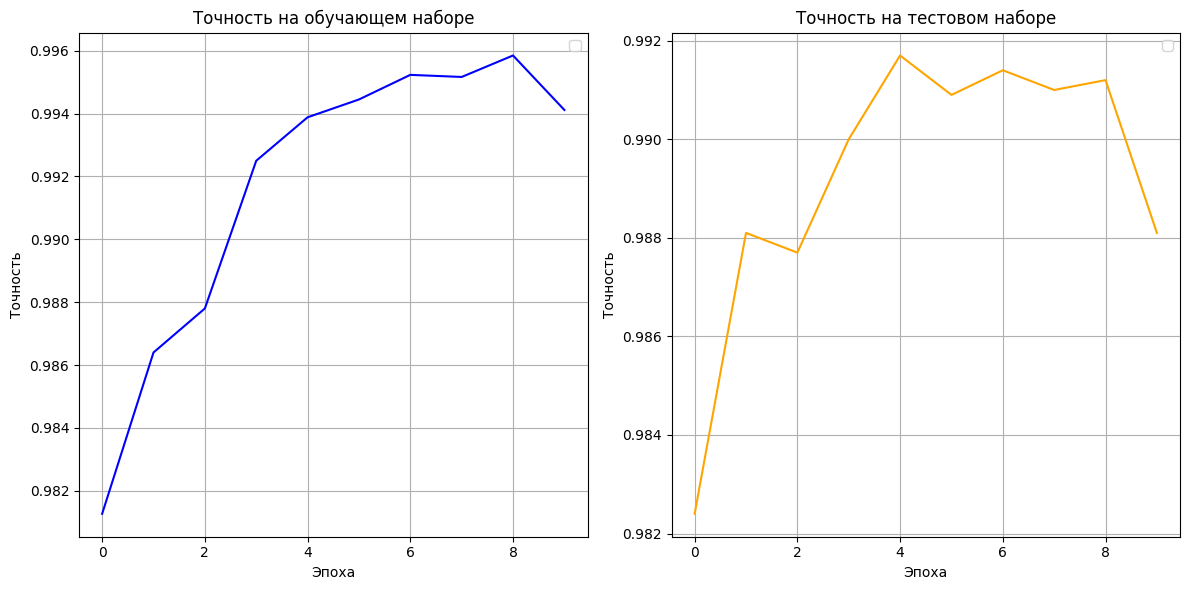

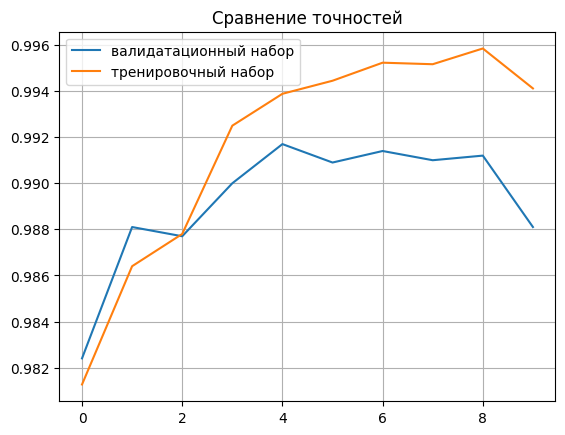

In [102]:
# Построение графиков точности
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(train_accuracy_history, color='blue')
ax1.set_title("Точность на обучающем наборе")
ax1.set_xlabel("Эпоха")
ax1.set_ylabel("Точность")
ax1.grid(True)
ax1.legend()

ax2.plot(test_accuracy_history, color='orange')
ax2.set_title("Точность на тестовом наборе")
ax2.set_xlabel("Эпоха")
ax2.set_ylabel("Точность")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig("точность_1.jpg")
plt.show()

plt.plot(test_accuracy_history, label="валидатационный набор")
plt.plot(train_accuracy_history, label="тренировочный набор")
plt.title("Сравнение точностей")
plt.legend()
plt.savefig("точность_2.jpg")
plt.grid(True)

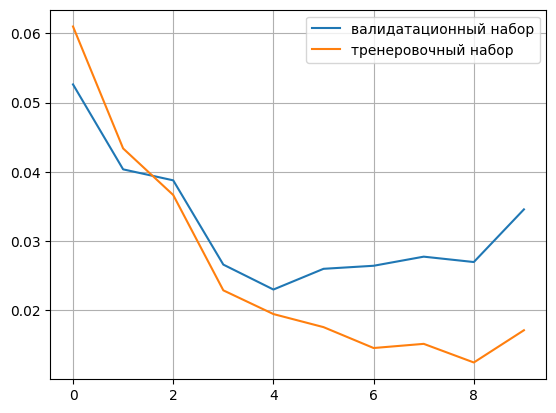

In [103]:
plt.plot(test_loss_history, label = "валидатационный набор");
plt.plot(train_loss_history, label = "тренеровочный набор");
plt.legend()
plt.savefig("ошибка.jpg")
plt.grid(True)

In [105]:
ac_history = []
l_history = []
test_size = 1000

order = np.random.permutation(len(X_test))
numerator = 0
for start_index in range(0, len(X_test), test_size):
    numerator += 1
    batch_indexes = order[start_index:start_index+test_size]
    X_batch = X_test[batch_indexes]
    y_batch = y_test[batch_indexes]
    preds = lenet5(X_batch)
    ac = (preds.argmax(dim=1) == y_batch).float().mean().item()
    ac_history.append(ac)
    loss_val = loss(preds, y_batch)
    l_history.append(loss_val.item())
    print(f'точность для запуска {numerator}: {ac}')

n_ac = len(ac_history)
mean_ac = sum(ac_history) / n_ac
variance_ac = sum((x - mean_ac) ** 2 for x in ac_history) / (n_ac - 1)

n_loss = len(l_history)
mean_loss = sum(l_history) / n_loss
variance_loss = sum((x - mean_loss) ** 2 for x in l_history) / (n_loss - 1)

print('\n')
print(f"Средняя точность: {mean_ac:.10f}")
print(f"Дисперсия точности: {variance_ac:.10f}")
print(f"Дисперсия целевой метрики: {variance_loss:.10f}")

точность для запуска 1: 0.9860000014305115
точность для запуска 2: 0.9869999885559082
точность для запуска 3: 0.9950000047683716
точность для запуска 4: 0.9909999966621399
точность для запуска 5: 0.9850000143051147
точность для запуска 6: 0.9879999756813049
точность для запуска 7: 0.9860000014305115
точность для запуска 8: 0.9890000224113464
точность для запуска 9: 0.9869999885559082
точность для запуска 10: 0.9869999885559082


Средняя точность: 0.9880999982
Дисперсия точности: 0.0000087667
Дисперсия целевой метрики: 0.0000954928


In [106]:
########################################################
class LeNet5_conv(torch.nn.Module):
    def __init__(self):
        super(LeNet5_conv, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2_new = torch.nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.bn2_new = torch.nn.BatchNorm2d(16)
        self.act2_new = torch.nn.ReLU()
        self.pool2_new = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=4)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(5 * 5 * 32, 128)
        self.act3 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(128, 104)
        self.act4 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(104, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2_new(self.act2_new(self.bn2_new(self.conv2_new(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)
        return x

lenet5 = LeNet5_conv()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)


In [107]:

batch_size = 100
num_epochs = 10

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

start_time = time.time()
for epoch in range(num_epochs):
    lenet5.train()
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        preds = lenet5(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # Валидация
    with torch.no_grad():
        lenet5.eval()
        test_preds = lenet5(X_test)
        test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        train_preds = lenet5(X_train)
        train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().item()
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(loss(train_preds, y_train).data.cpu())

    print(f'эпоха: {epoch + 1}/{num_epochs}, точность на тестовом наборе: {test_accuracy:.4f}, точность на тренировочном наборе: {train_accuracy:.4f}')

end_time = time.time()
time_his.append(end_time - start_time)

эпоха: 1/10, точность на тестовом наборе: 0.9813, точность на тренировочном наборе: 0.9811
эпоха: 2/10, точность на тестовом наборе: 0.9870, точность на тренировочном наборе: 0.9872
эпоха: 3/10, точность на тестовом наборе: 0.9823, точность на тренировочном наборе: 0.9822
эпоха: 4/10, точность на тестовом наборе: 0.9868, точность на тренировочном наборе: 0.9913
эпоха: 5/10, точность на тестовом наборе: 0.9901, точность на тренировочном наборе: 0.9939
эпоха: 6/10, точность на тестовом наборе: 0.9863, точность на тренировочном наборе: 0.9905
эпоха: 7/10, точность на тестовом наборе: 0.9893, точность на тренировочном наборе: 0.9940
эпоха: 8/10, точность на тестовом наборе: 0.9889, точность на тренировочном наборе: 0.9937
эпоха: 9/10, точность на тестовом наборе: 0.9901, точность на тренировочном наборе: 0.9955
эпоха: 10/10, точность на тестовом наборе: 0.9902, точность на тренировочном наборе: 0.9963


In [108]:
class LeNet5_lin(torch.nn.Module):
    def __init__(self):
        super(LeNet5_lin, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 240)
        self.act3 = torch.nn.ReLU()

        # Новый полносвязный слой
        self.fc2 = torch.nn.Linear(240, 128)
        self.act4 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)
        return x

lenet5 = LeNet5_lin()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)


In [109]:

batch_size = 100
num_epochs = 10

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

start_time = time.time()
for epoch in range(num_epochs):
    lenet5.train()
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        preds = lenet5(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # Валидация
    with torch.no_grad():
        lenet5.eval()
        test_preds = lenet5(X_test)
        test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        train_preds = lenet5(X_train)
        train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().item()
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(loss(train_preds, y_train).data.cpu())

    print(f'эпоха: {epoch + 1}/{num_epochs}, точность на тестовом наборе: {test_accuracy:.4f}, точность на тренировочном наборе: {train_accuracy:.4f}')

end_time = time.time()
time_his.append(end_time - start_time)

эпоха: 1/10, точность на тестовом наборе: 0.9777, точность на тренировочном наборе: 0.9769
эпоха: 2/10, точность на тестовом наборе: 0.9859, точность на тренировочном наборе: 0.9876
эпоха: 3/10, точность на тестовом наборе: 0.9894, точность на тренировочном наборе: 0.9906
эпоха: 4/10, точность на тестовом наборе: 0.9896, точность на тренировочном наборе: 0.9924
эпоха: 5/10, точность на тестовом наборе: 0.9887, точность на тренировочном наборе: 0.9916
эпоха: 6/10, точность на тестовом наборе: 0.9888, точность на тренировочном наборе: 0.9934
эпоха: 7/10, точность на тестовом наборе: 0.9902, точность на тренировочном наборе: 0.9936
эпоха: 8/10, точность на тестовом наборе: 0.9889, точность на тренировочном наборе: 0.9931
эпоха: 9/10, точность на тестовом наборе: 0.9921, точность на тренировочном наборе: 0.9968
эпоха: 10/10, точность на тестовом наборе: 0.9898, точность на тренировочном наборе: 0.9957


In [115]:
print(f'{time_his[0]:.4f} - время обучения нейронной сети в базовом варианте')
print(f'{time_his[2]:.4f} - время обучения нейронной сети с дополнительным полносвязным слоем')
print(f'{time_his[1]:.4f} - время обучения нейронной сети с дополнительный сверточным слоем')

291.0370 - время обучения нейронной сети в базовом варианте
294.2573 - время обучения нейронной сети с дополнительным полносвязным слоем
612.3594 - время обучения нейронной сети с дополнительный сверточным слоем


Сверточные слои медленнее полносвязных, потому что:
•	Они выполняют больше вычислений из-за прохода ядра по каждой области входа.
•	Они обрабатывают многомерные данные (тензоры), что увеличивает вычислительную нагрузку.
•	Требуется больше памяти для промежуточных результатов.
